## Evaluate Hawkes Process Model
Noam Siegel, Ben Gurion University

In [1]:
import gpytorch
import torch
import yaml
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

from msc.canine_db_utils import get_record_start, get_onsets, get_ipp_training_data
from msc.models import InteractingPointProcessGPModel, HawkesProcessGP
%load_ext autoreload
%autoreload 2

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\noam\.virtualenvs\msc-WSmVxSSb\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
dog_num = 3
model_version = '0.1.1'
hparams_fpath = fr"C:\Users\noam\Repositories\noamsgl\msc\results\lightning_logs\prior\ipp\ipp_prior\{model_version}\hparams.yaml"

with open(hparams_fpath, 'r') as stream:
    hparams = yaml.safe_load(stream)

train_x, train_y = get_ipp_training_data(dog_num, hparams['time_step'])
hparams

{'enable_progress_bar': True,
 'fast_dev_run': False,
 'graphic_verbose': True,
 'learning_rate': 0.01,
 'n_epochs': 800,
 'random_seed': 42,
 'time_step': 7200,
 'version': '0.1.1'}

In [3]:
state_dict = torch.load(fr"C:\Users\noam\Repositories\noamsgl\msc\results\lightning_logs\prior\ipp\ipp_prior\{model_version}\checkpoints\gp_ipp_state_dict.pth")
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
model = HawkesProcessGP(train_x, likelihood)

Text(0.5, 1.0, 'Prior')

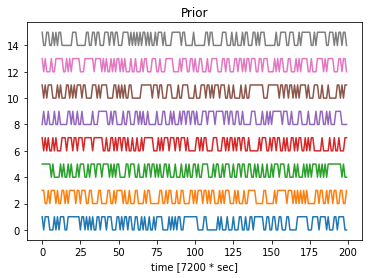

In [4]:
# plot prior samples
prior_distribution = model.likelihood(model(train_x))
n_draws = 8
for i in range(n_draws):
    plt.plot(train_x[:200], (prior_distribution.sample() + 2 * i)[:200])
plt.xlabel(f"time [{hparams['time_step']} * sec]")
plt.title('Prior')

In [5]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Text(0.5, 1.0, 'Posterior')

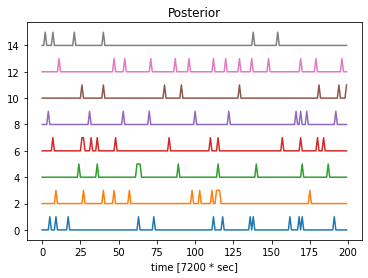

In [6]:
# plot posterior samples
posterior_distribution = model.likelihood(model(train_x))
n_draws = 8
for i in range(n_draws):
    plt.plot(train_x[:200], (posterior_distribution.sample() + 2 * i)[:200])
plt.xlabel(f"time [{hparams['time_step']} * sec]")
plt.title('Posterior')

## Get inter-seizure intervals
In this section we will check the posterior distribution.
We expect the mean and variance of the inter-seizure intervals to fluctuate around the observed values.

### Observation intervals

In [7]:
obs_intervals = train_y.nonzero().diff(dim=0).squeeze().double()

In [8]:
stats.describe(obs_intervals)

DescribeResult(nobs=44, minmax=(1.0, 2838.0), mean=118.86363636363636, variance=193594.53911205073, skewness=5.571514641080751, kurtosis=31.73906083863701)

### Draw posterior predictive interval samples

In [9]:
n_samples = 1000
samples = posterior_distribution.sample((n_samples,))

In [10]:
samples.size()

torch.Size([1000, 5400])

In [11]:
intervals = [samples[i].nonzero().diff(dim=0).squeeze().double() for i in range(len(samples))]

### Plot test statistics

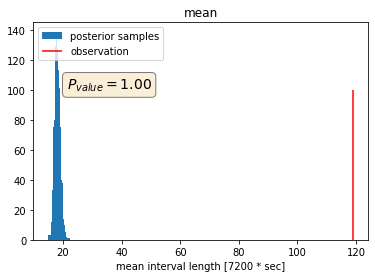

In [12]:
intervals_means = [torch.mean(inters).item() for inters in intervals]
plt.hist(intervals_means, bins=20, label='posterior samples')
plt.vlines(torch.mean(obs_intervals), 0, 100, colors='r', label='observation')
plt.legend(loc = 'upper left')
plt.xlabel(f"mean interval length [{hparams['time_step']} * sec]")
plt.title('mean')
# place a text box with the p_value in the upper right in axes coords
p_value = len([interv_mean for interv_mean in intervals_means if interv_mean < torch.mean(obs_intervals)])/len(intervals_means)
ax = plt.gca()
textstr = r'$P_{value}=%.2f$' % (p_value)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.1, 0.75, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left',bbox=props);

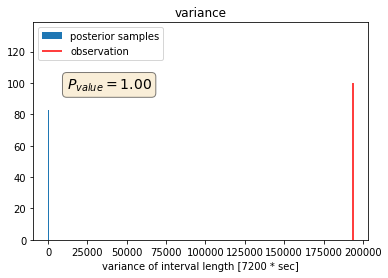

In [13]:
intervals_vars = [torch.var(inters).item() for inters in intervals]
plt.hist(intervals_vars, bins=20, label="posterior samples")
plt.vlines(torch.var(obs_intervals), 0, 100, colors='r', label="observation")
plt.legend(loc = 'upper left')
plt.xlabel(f"variance of interval length [{hparams['time_step']} * sec]")
plt.title(f"variance")
# place a text box with the p_value in the upper right in axes coords
p_value = len([interv_var for interv_var in intervals_vars if interv_var < torch.var(obs_intervals)])/len(intervals_vars)
ax = plt.gca()
textstr = r'$P_{value}=%.2f$' % (p_value)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.1, 0.75, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left',bbox=props);

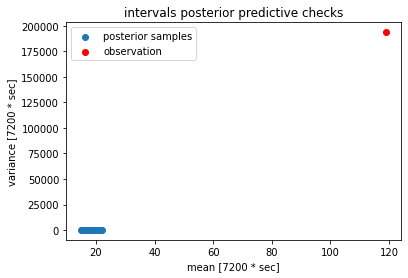

In [14]:
plt.scatter(intervals_means, intervals_vars, label="posterior samples")
plt.scatter(torch.mean(obs_intervals), torch.var(obs_intervals), c='r', label="observation")
plt.xlabel(f"mean [{hparams['time_step']} * sec]")
plt.ylabel(f"variance [{hparams['time_step']} * sec]")
plt.legend()
plt.title('intervals posterior predictive checks');